In [1]:
%%writefile test.cu
#include <stdio.h>

__global__ void hello_from_gpu_kernel() {
    printf("Hello from GPU! thread %d\n", threadIdx.x);
    // Removed: fflush(stdout); // Host-side function, not allowed in __global__
}

int main() {
    printf("Launching a simple GPU kernel...\n");
    hello_from_gpu_kernel<<<1, 5>>>(); // 5つのスレッドでカーネルを起動
    cudaDeviceSynchronize(); // GPUの処理が完了するまで待機
    printf("GPU kernel finished. Program exiting.\n");
    return 0;
}

Writing test.cu


In [2]:
!nvcc test.cu -o test -gencode arch=compute_75,code=sm_75

In [3]:
!./test

Launching a simple GPU kernel...
Hello from GPU! thread 0
Hello from GPU! thread 1
Hello from GPU! thread 2
Hello from GPU! thread 3
Hello from GPU! thread 4
GPU kernel finished. Program exiting.


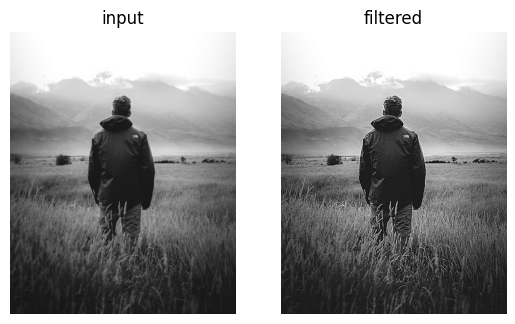

In [5]:
import cupy as cp
import numpy as np
import imageio.v3 as iio

# 入力画像を読み込み (グレースケール化)
img_cpu = iio.imread("https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d?auto=format&fit=crop&w=512&q=60", pilmode="L")
h, w = img_cpu.shape
img = cp.asarray(img_cpu, dtype=cp.float32)

# 3x3 シャープ化フィルタ
kernel = cp.asarray([[0, -1, 0],
                     [-1, 5, -1],
                     [0, -1, 0]], dtype=cp.float32)

# CUDAカーネル（各画素に1スレッド）
code = r'''
extern "C" __global__
void conv2d(const float* img, const float* k, float* out, int h, int w) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= w || y >= h) return;

    float acc = 0.f;
    // 3x3フィルタ固定
    #pragma unroll
    for (int ky = -1; ky <= 1; ++ky) {
        int iy = min(max(y + ky, 0), h - 1);
        #pragma unroll
        for (int kx = -1; kx <= 1; ++kx) {
            int ix = min(max(x + kx, 0), w - 1);
            float kval = k[(ky + 1) * 3 + (kx + 1)];
            acc += img[iy * w + ix] * kval;
        }
    }
    out[y * w + x] = acc;
}
'''
conv2d = cp.RawKernel(code, "conv2d")

# 出力バッファ
out = cp.empty_like(img)

# ブロック・グリッド設定
block = (16, 16)
grid = ((w + block[0] - 1) // block[0], (h + block[1] - 1) // block[1])

# 実行
conv2d(grid, block, (img, kernel, out, h, w))

# CPUへ戻して表示
out_cpu = cp.asnumpy(out).clip(0, 255).astype(np.uint8)

import matplotlib.pyplot as plt
plt.subplot(1,2,1); plt.title("input"); plt.imshow(img_cpu, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("filtered"); plt.imshow(out_cpu, cmap="gray"); plt.axis("off")
plt.show()


In [6]:
%%writefile conv2d.cu
#include <cstdio>
#include <vector>
#include <algorithm>
#include <cuda_runtime.h>
#define CHECK(call) do{cudaError_t e=call; if(e!=cudaSuccess){fprintf(stderr,"CUDA error %s:%d: %s\n",__FILE__,__LINE__,cudaGetErrorString(e)); exit(1);} }while(0)

__global__ void conv2d(const float* img, const float* k, float* out, int h, int w) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if (x >= w || y >= h) return;

    float acc = 0.f;
    #pragma unroll
    for (int ky = -1; ky <= 1; ++ky) {
        int iy = min(max(y + ky, 0), h - 1);
        #pragma unroll
        for (int kx = -1; kx <= 1; ++kx) {
            int ix = min(max(x + kx, 0), w - 1);
            acc += img[iy * w + ix] * k[(ky + 1) * 3 + (kx + 1)];
        }
    }
    out[y * w + x] = acc;
}

int main() {
    const int h = 512, w = 512;
    std::vector<float> img(h * w, 0.0f);
    // テスト用: 中央に白い矩形
    for (int y = 200; y < 312; ++y)
        for (int x = 200; x < 312; ++x) img[y * w + x] = 255.0f;

    float h_k[9] = {0, -1, 0, -1, 5, -1, 0, -1, 0}; // シャープ化
    float *d_img, *d_k, *d_out;
    CHECK(cudaMalloc(&d_img, h * w * sizeof(float)));
    CHECK(cudaMalloc(&d_k, 9 * sizeof(float)));
    CHECK(cudaMalloc(&d_out, h * w * sizeof(float)));
    CHECK(cudaMemcpy(d_img, img.data(), h * w * sizeof(float), cudaMemcpyHostToDevice));
    CHECK(cudaMemcpy(d_k, h_k, 9 * sizeof(float), cudaMemcpyHostToDevice));

    dim3 block(16, 16);
    dim3 grid((w + block.x - 1) / block.x, (h + block.y - 1) / block.y);
    conv2d<<<grid, block>>>(d_img, d_k, d_out, h, w);
    CHECK(cudaPeekAtLastError());
    CHECK(cudaDeviceSynchronize());

    std::vector<float> out(h * w);
    CHECK(cudaMemcpy(out.data(), d_out, h * w * sizeof(float), cudaMemcpyDeviceToHost));

    // 画素の一部を表示
    for (int y = 200; y < 206; ++y) {
        for (int x = 200; x < 206; ++x) printf("%6.1f ", out[y * w + x]);
        printf("\n");
    }

    cudaFree(d_img); cudaFree(d_k); cudaFree(d_out);
    return 0;
}


Writing conv2d.cu


In [7]:
!nvcc -O2 conv2d.cu -o conv2d
!./conv2d

CUDA error conv2d.cu:43: the provided PTX was compiled with an unsupported toolchain.


In [8]:
%%bash
arch=sm_75  # 上の表に合わせて変更

nvcc -O2 -std=c++17 -arch=${arch} -code=${arch} conv2d.cu -o conv2d
./conv2d


nvcc fatal   : Value of -arch option ('sm_75') must be a virtual code architecture
CUDA error conv2d.cu:43: the provided PTX was compiled with an unsupported toolchain.


CalledProcessError: Command 'b'arch=sm_75  # \xe4\xb8\x8a\xe3\x81\xae\xe8\xa1\xa8\xe3\x81\xab\xe5\x90\x88\xe3\x82\x8f\xe3\x81\x9b\xe3\x81\xa6\xe5\xa4\x89\xe6\x9b\xb4\n\nnvcc -O2 -std=c++17 -arch=${arch} -code=${arch} conv2d.cu -o conv2d\n./conv2d\n'' returned non-zero exit status 1.